In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==3
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/compute_settings.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/algconf_settings.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/democonf_settings.json
Will read from /media/data/hastings/2d-registration/notebook/../mermaid/mermaid/../mermaid_settings/democonf_setting

In [3]:
import matplotlib.pyplot as plt

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = RegisNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        
        regularization_loss = 300 * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        #print(regularization_loss, similarity_loss)
        
        self.all_loss = regularization_loss + similarity_loss


net = MermaidNet()
0

0

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

In [9]:
net.train()

MermaidNet(
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [37]:
for _ in range(100):
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == 128:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.all_loss
            
            loss.backward()
            optimizer.step()


In [38]:
moving, fixed = list(zip(d1, d2))[0]
moving_image = moving[0].cuda()
fixed_image = fixed[0].cuda()

net(moving_image, fixed_image)

phi = np.array((net.phi1).cpu().detach())
iden = np.array(net.identityMap.cpu())

In [39]:
iden.shape

(128, 2, 28, 28)

In [40]:
N = 0

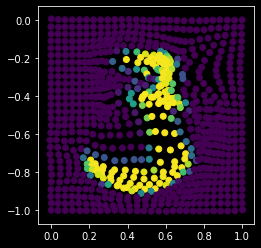

In [41]:
N = N + 1
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

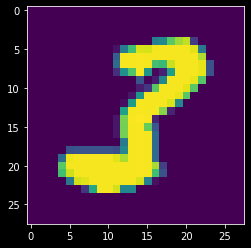

In [42]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

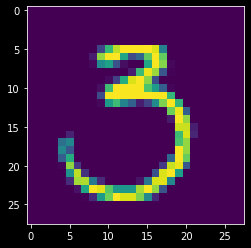

In [43]:
plt.imshow(moving_image[N, 0].cpu().numpy())

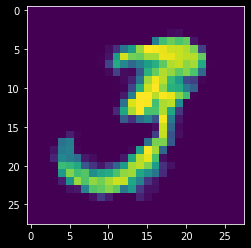

In [44]:
plt.imshow(net.warped_moving_image[N, 0].detach().cpu())

In [45]:
def get_phi(a, b):
    net(a, b)
    return net.phi1.detach().cpu()

In [46]:
phi1 = get_phi(moving_image, fixed_image)
phi2 = get_phi(fixed_image, moving_image)

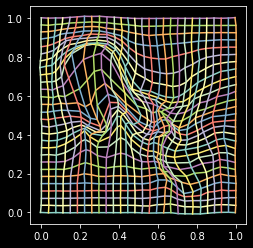

In [47]:
def grid(A, B):
    plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))


grid(phi2[N, 0], phi2[N, 1])


In [48]:
grid

<function __main__.grid(A, B)>

In [49]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)

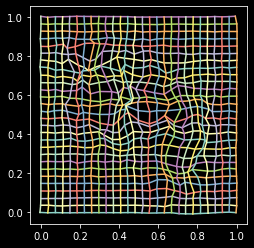

In [50]:
grid(ident_hope[N, 0], ident_hope[N, 1])

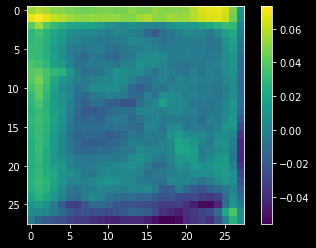

In [46]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

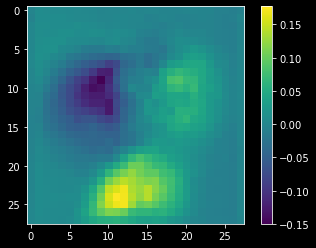

In [83]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [27]:
net.phi.size()

torch.Size([128, 2, 28, 28])